In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Layer, Reshape, Multiply, Conv2D, BatchNormalization, Activation, Add, Input, ZeroPadding2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import glorot_uniform
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedShuffleSplit


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [2]:
base = '/Users/robp/scm/personal/github.com/robpickerill/thesis'
csv_file = os.path.join(base, 'ham10000_data/HAM10000_metadata.csv')
img_dir = os.path.join(base, 'ham10000_data/images')
file_ext = '.jpg'

df = pd.read_csv(csv_file)
df['image_path'] = df['image_id'].apply(lambda x: os.path.join(img_dir, x + file_ext))

print(df.head())


     lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                          image_path  
0  /Users/robp/scm/personal/github.com/robpickeri...  
1  /Users/robp/scm/personal/github.com/robpickeri...  
2  /Users/robp/scm/personal/github.com/robpickeri...  
3  /Users/robp/scm/personal/github.com/robpickeri...  
4  /Users/robp/scm/personal/github.com/robpickeri...  


In [3]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in sss.split(df, df['dx']):
    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

print("Train size: ", len(train_df))
print("Train sizes per label and percentage:")
train_counts = train_df['dx'].value_counts()
train_percentages = (train_counts / len(train_df)) * 100
print(train_counts)
print(train_percentages)

print("\nTest size: ", len(test_df))
print("Test sizes per label and percentage:")
test_counts = test_df['dx'].value_counts()
test_percentages = (test_counts / len(test_df)) * 100
print(test_counts)
print(test_percentages)

Train size:  8012
Train sizes per label and percentage:
dx
nv       5364
mel       890
bkl       879
bcc       411
akiec     262
vasc      114
df         92
Name: count, dtype: int64
dx
nv       66.949576
mel      11.108337
bkl      10.971043
bcc       5.129805
akiec     3.270095
vasc      1.422866
df        1.148278
Name: count, dtype: float64

Test size:  2003
Test sizes per label and percentage:
dx
nv       1341
mel       223
bkl       220
bcc       103
akiec      65
vasc       28
df         23
Name: count, dtype: int64
dx
nv       66.949576
mel      11.133300
bkl      10.983525
bcc       5.142287
akiec     3.245132
vasc      1.397903
df        1.148278
Name: count, dtype: float64


In [4]:
IMG_SIZE = 224
BATCH_SIZE = 32

datagen_train = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen_test = ImageDataGenerator(rescale=1.0/255.0)

train_generator = datagen_train.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='dx',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

test_generator = datagen_test.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='dx',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=42,
)

class_names = [key for key, _ in sorted(train_generator.class_indices.items(), key=lambda item: item[1])]

train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, IMG_SIZE, IMG_SIZE, 3], [None, len(class_names)])
).repeat()
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_generator(
    lambda: test_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, IMG_SIZE, IMG_SIZE, 3], [None, len(class_names)])
).repeat()
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

print("Class Names:", class_names)
print("Train Generator Class Indices:", train_generator.class_indices)
print("Test Generator Class Indices:", test_generator.class_indices)

Found 8012 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.
Class Names: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Train Generator Class Indices: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
Test Generator Class Indices: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [5]:
# Source: https://github.com/keras-team/keras/blob/v3.7.0/keras/src/applications/resnet.py#L219
# This implementation of ResNet50 is adapted from the official Keras implementation,
# to enable the modification of the architecture to support attention mechanisms.

def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of the middle conv layer at the main path
        filters: list of integers, the filters of the 3 conv layers at the main path
        stage: integer, current stage label, used for layer naming
        block: string/char, current block label, used for layer naming
    """
    # Use channels_last
    bn_axis = 3
    filters1, filters2, filters3 = filters
    conv_name_base = 'conv' + str(stage) + '_block' + str(block) + '_'

    x = Conv2D(filters1, (1, 1),
               use_bias=True,
               kernel_initializer='he_normal',
               name=conv_name_base + '1_conv')(input_tensor)
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=conv_name_base + '1_bn')(x)
    x = Activation('relu', name=conv_name_base + '1_relu')(x)

    x = Conv2D(filters2, kernel_size,
               padding='same',
               use_bias=True,
               kernel_initializer='he_normal',
               name=conv_name_base + '2_conv')(x)
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=conv_name_base + '2_bn')(x)
    x = Activation('relu', name=conv_name_base + '2_relu')(x)

    x = Conv2D(filters3, (1, 1),
               use_bias=True,
               kernel_initializer='he_normal',
               name=conv_name_base + '3_conv')(x)
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=conv_name_base + '3_bn')(x)

    x = Add(name=conv_name_base + 'add')([x, input_tensor])
    x = Activation('relu', name=conv_name_base + 'out')(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """A block that has a conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of the middle conv layer at the main path
        filters: list of integers, the filters of the 3 conv layers at the main path
        stage: integer, current stage label, used for layer naming
        block: string/char, current block label, used for layer naming
        strides: Strides for the first conv layer in the block.
    """
    bn_axis = 3
    filters1, filters2, filters3 = filters
    conv_name_base = 'conv' + str(stage) + '_block' + str(block) + '_'

    x = Conv2D(filters1, (1, 1), strides=strides,
               use_bias=True,
               kernel_initializer='he_normal',
               name=conv_name_base + '1_conv')(input_tensor)
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=conv_name_base + '1_bn')(x)
    x = Activation('relu', name=conv_name_base + '1_relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same',
               use_bias=True,
               kernel_initializer='he_normal',
               name=conv_name_base + '2_conv')(x)
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=conv_name_base + '2_bn')(x)
    x = Activation('relu', name=conv_name_base + '2_relu')(x)

    x = Conv2D(filters3, (1, 1),
               use_bias=True,
               kernel_initializer='he_normal',
               name=conv_name_base + '3_conv')(x)
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=conv_name_base + '3_bn')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides,
                      use_bias=True,
                      kernel_initializer='he_normal',
                      name=conv_name_base + '0_conv')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=conv_name_base + '0_bn')(shortcut)

    x = Add(name=conv_name_base + 'add')([x, shortcut])
    x = Activation('relu', name=conv_name_base + 'out')(x)
    return x

def build_resnet50(input_shape, num_classes):
    inputs = Input(shape=input_shape, name='input_1')
    bn_axis = 3  # channels_last

    x = ZeroPadding2D(padding=(3, 3), name='conv1_pad')(inputs)
    x = Conv2D(64, (7, 7), strides=(2, 2),
               padding='valid', use_bias=True,
               kernel_initializer='he_normal',
               name='conv1_conv')(x)
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name='conv1_bn')(x)
    x = Activation('relu', name='conv1_relu')(x)
    x = ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), name='pool1_pool')(x)

    # Stage 2
    x = conv_block(x, 3, [64, 64, 256], stage=2, block=1, strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block=2)
    x = identity_block(x, 3, [64, 64, 256], stage=2, block=3)

    # Stage 3
    x = conv_block(x, 3, [128, 128, 512], stage=3, block=1)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block=2)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block=3)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block=4)

    # Stage 4
    x = conv_block(x, 3, [256, 256, 1024], stage=4, block=1)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=2)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=3)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=4)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=5)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=6)

    # Stage 5
    x = conv_block(x, 3, [512, 512, 2048], stage=5, block=1)
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block=2)
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block=3)

    x = GlobalAveragePooling2D(name='avg_pool')(x)

    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax', name='predictions')(x)

    model = Model(inputs, outputs, name='resnet50')
    return model


In [6]:
def transfer_weights(base_model, target_model):
    for layer in target_model.layers:
        try:
            pretrained_layer = base_model.get_layer(layer.name)
            layer.set_weights(pretrained_layer.get_weights())
        except Exception as e:
            print(f"Could not transfer weights for layer: {layer.name}, due to: {e}")
            pass

In [7]:
base_model = ResNet50(weights="imagenet", include_top=False, pooling=None)

# Build ResNet50 with SE Blocks
input_shape = (224, 224, 3)
num_classes = 7
custom_resnet = build_resnet50(input_shape, num_classes)

# Transfer weights
transfer_weights(base_model, custom_resnet)

custom_resnet.summary()

# Switch the custom_resnet to being the model
model = custom_resnet

# Freeze the base model
for layer in model.layers:
    if layer.name.startswith('conv1') or layer.name.startswith('conv2') or layer.name.startswith('conv3') or layer.name.startswith('conv4') or layer.name.startswith('conv5'):
        layer.trainable = False


Could not transfer weights for layer: input_1, due to: No such layer: input_1. Existing layers are: ['input_layer', 'conv1_pad', 'conv1_conv', 'conv1_bn', 'conv1_relu', 'pool1_pad', 'pool1_pool', 'conv2_block1_1_conv', 'conv2_block1_1_bn', 'conv2_block1_1_relu', 'conv2_block1_2_conv', 'conv2_block1_2_bn', 'conv2_block1_2_relu', 'conv2_block1_0_conv', 'conv2_block1_3_conv', 'conv2_block1_0_bn', 'conv2_block1_3_bn', 'conv2_block1_add', 'conv2_block1_out', 'conv2_block2_1_conv', 'conv2_block2_1_bn', 'conv2_block2_1_relu', 'conv2_block2_2_conv', 'conv2_block2_2_bn', 'conv2_block2_2_relu', 'conv2_block2_3_conv', 'conv2_block2_3_bn', 'conv2_block2_add', 'conv2_block2_out', 'conv2_block3_1_conv', 'conv2_block3_1_bn', 'conv2_block3_1_relu', 'conv2_block3_2_conv', 'conv2_block3_2_bn', 'conv2_block3_2_relu', 'conv2_block3_3_conv', 'conv2_block3_3_bn', 'conv2_block3_add', 'conv2_block3_out', 'conv3_block1_1_conv', 'conv3_block1_1_bn', 'conv3_block1_1_relu', 'conv3_block1_2_conv', 'conv3_block1_2_

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_1             │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_1 (Cast)       │ (None, 224, 224,  │          0 │ input_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ cast_1[0][0]      │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,602,055 (90.03 MB)

 Trainable params: 23,548,935 (89.83 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [8]:
def focal_loss(alpha=0.25, gamma=2.0):
    """
    Focal Loss for one-hot encoded multi-class data.
    Source:
    https://github.com/fizyr/keras-retinanet/blob/main/keras_retinanet/losses.py
    Paper:
    https://arxiv.org/abs/1708.02002


    Parameters:
    - alpha: Weighting factor for positive classes, default is 0.25.
    - gamma: Focusing parameter to reduce the loss contribution from well-classified examples, default is 2.0.

    Returns:
    - A callable loss function for use with Keras models.
    """
    def focal_loss_fixed(y_true, y_pred):
        # Clip predictions to prevent log(0)
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1. - tf.keras.backend.epsilon())

        # Compute focal loss components
        cross_entropy = -y_true * tf.math.log(y_pred)
        weights = alpha * y_true * tf.math.pow(1 - y_pred, gamma)

        # Compute weighted loss
        focal_loss = tf.reduce_sum(weights * cross_entropy, axis=-1)
        return tf.reduce_mean(focal_loss)

    return focal_loss_fixed

In [9]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=focal_loss(),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

In [10]:
model_path = 'models/resnet50_crossentropy.keras'

callbacks = [
    EarlyStopping(monitor='val_auc', patience=3, verbose=1, restore_best_weights=True, mode='max'),
    ModelCheckpoint(filepath=model_path, monitor='val_auc', save_best_only=True, verbose=1, mode='max')
]

In [11]:
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.array(class_names),
    y=df['dx']
)

class_weights_dict = {
    train_generator.class_indices[class_name]: weight
    for class_name, weight in zip(class_names, class_weights_array)
}

print(class_weights_dict)

{0: 4.375273044997815, 1: 2.78349082823791, 2: 1.301832835044846, 3: 12.440993788819876, 4: 1.2854575792581184, 5: 0.21338020666879728, 6: 10.075452716297788}


In [12]:
steps_per_epoch = len(train_df) // BATCH_SIZE
validation_steps = len(test_df) // BATCH_SIZE

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.5770 - auc: 0.8362 - loss: 0.2415
Epoch 1: val_auc improved from -inf to 0.88709, saving model to models/resnet50_crossentropy.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 71s 271ms/step - accuracy: 0.5772 - auc: 0.8362 - loss: 0.2414 - val_accuracy: 0.6699 - val_auc: 0.8871 - val_loss: 0.1723
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.6643 - auc: 0.8712 - loss: 0.1933
Epoch 2: val_auc improved from 0.88709 to 0.88863, saving model to models/resnet50_crossentropy.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 68s 273ms/step - accuracy: 0.6643 - auc: 0.8712 - loss: 0.1933 - val_accuracy: 0.6699 - val_auc: 0.8886 - val_loss: 0.1707
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.6655 - auc: 0.8714 - loss: 0.1954
Epoch 3: val_auc improved from 0.88863 to 0.89587, saving model to models/resnet50_crossentropy.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 69s 275ms/step - accuracy: 0.6655 - auc: 0.8714 - loss: 0.

In [13]:
for layer in model.layers:
    layer.trainable = True
    print(layer.name, layer.trainable)

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=focal_loss(),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)


input_1 True
conv1_pad True
conv1_conv True
conv1_bn True
conv1_relu True
pool1_pad True
pool1_pool True
conv2_block1_1_conv True
conv2_block1_1_bn True
conv2_block1_1_relu True
conv2_block1_2_conv True
conv2_block1_2_bn True
conv2_block1_2_relu True
conv2_block1_3_conv True
conv2_block1_0_conv True
conv2_block1_3_bn True
conv2_block1_0_bn True
conv2_block1_add True
conv2_block1_out True
conv2_block2_1_conv True
conv2_block2_1_bn True
conv2_block2_1_relu True
conv2_block2_2_conv True
conv2_block2_2_bn True
conv2_block2_2_relu True
conv2_block2_3_conv True
conv2_block2_3_bn True
conv2_block2_add True
conv2_block2_out True
conv2_block3_1_conv True
conv2_block3_1_bn True
conv2_block3_1_relu True
conv2_block3_2_conv True
conv2_block3_2_bn True
conv2_block3_2_relu True
conv2_block3_3_conv True
conv2_block3_3_bn True
conv2_block3_add True
conv2_block3_out True
conv3_block1_1_conv True
conv3_block1_1_bn True
conv3_block1_1_relu True
conv3_block1_2_conv True
conv3_block1_2_bn True
conv3_block1

In [14]:
callbacks = [
    ReduceLROnPlateau(monitor='val_auc', factor=0.1, patience=3, verbose=1, mode='max', min_lr=1e-9),
    EarlyStopping(monitor='val_auc', patience=7, verbose=1, restore_best_weights=True, mode='max'),
    ModelCheckpoint(filepath=model_path, monitor='val_auc', save_best_only=True, verbose=1, mode='max')
]

In [15]:
fine_tune_history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=200,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks,
    class_weight=class_weights_dict
)


Epoch 1/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5451 - auc: 0.8450 - loss: 0.3765
Epoch 1: val_auc improved from -inf to 0.41087, saving model to models/resnet50_crossentropy.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 326s 1s/step - accuracy: 0.5453 - auc: 0.8452 - loss: 0.3762 - val_accuracy: 0.0323 - val_auc: 0.4109 - val_loss: 2.3453 - learning_rate: 1.0000e-05
Epoch 2/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6488 - auc: 0.9132 - loss: 0.2274
Epoch 2: val_auc improved from 0.41087 to 0.66377, saving model to models/resnet50_crossentropy.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 296s 1s/step - accuracy: 0.6488 - auc: 0.9132 - loss: 0.2273 - val_accuracy: 0.1784 - val_auc: 0.6638 - val_loss: 1.0868 - learning_rate: 1.0000e-05
Epoch 3/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6797 - auc: 0.9370 - loss: 0.1522
Epoch 3: val_auc improved from 0.66377 to 0.88387, saving model to models/resnet50_crossentropy.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 298s 1s/step

In [16]:
model.load_weights(model_path)


In [17]:
loss, accuracy, auc = model.evaluate(test_generator, steps=len(test_generator))

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test AUC: {auc}")

/Users/robp/scm/personal/github.com/robpickerill/thesis/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 219ms/step - accuracy: 0.8207 - auc: 0.9813 - loss: 0.0686
Test Loss: 0.059341538697481155
Test Accuracy: 0.8337493538856506
Test AUC: 0.9840118885040283


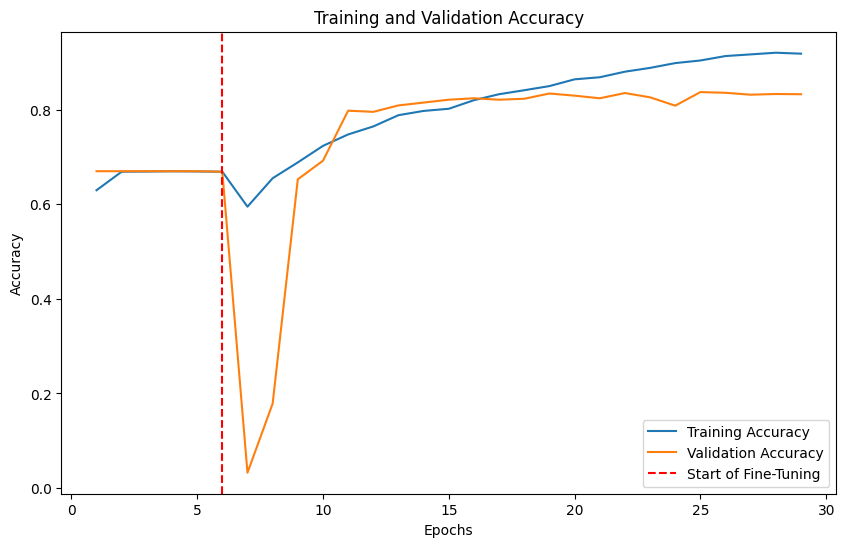

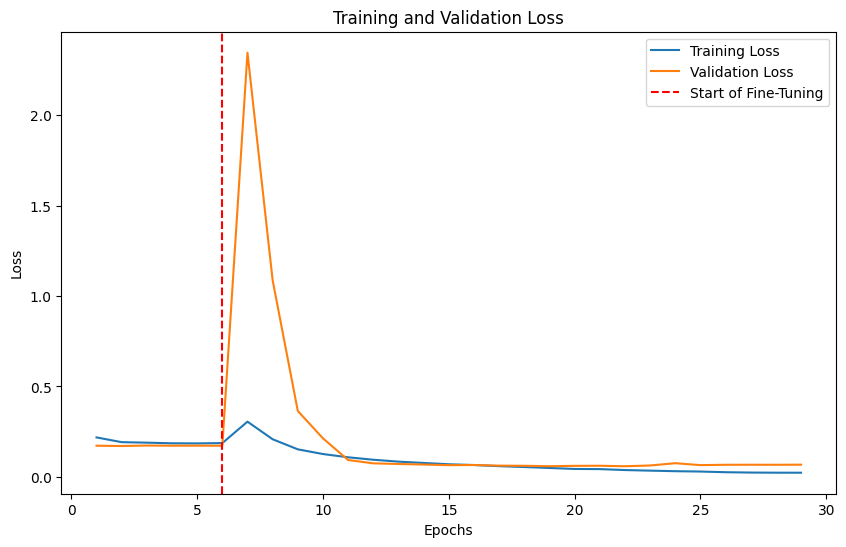

In [18]:
accuracy = history.history['accuracy'] + fine_tune_history.history['accuracy']
val_accuracy = history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']
loss = history.history['loss'] + fine_tune_history.history['loss']
val_loss = history.history['val_loss'] + fine_tune_history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.axvline(x=len(history.history['accuracy']), color='r', linestyle='--', label='Start of Fine-Tuning')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.axvline(x=len(history.history['loss']), color='r', linestyle='--', label='Start of Fine-Tuning')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [19]:
y_pred = np.argmax(model.predict(test_generator), axis=-1)
y_true = test_generator.classes

print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 243ms/step
Classification Report:
               precision    recall  f1-score   support

       akiec       0.76      0.48      0.58        65
         bcc       0.77      0.56      0.65       103
         bkl       0.55      0.83      0.66       220
          df       0.65      0.57      0.60        23
         mel       0.63      0.61      0.62       223
          nv       0.95      0.91      0.93      1341
        vasc       0.92      0.82      0.87        28

    accuracy                           0.83      2003
   macro avg       0.75      0.68      0.70      2003
weighted avg       0.85      0.83      0.84      2003



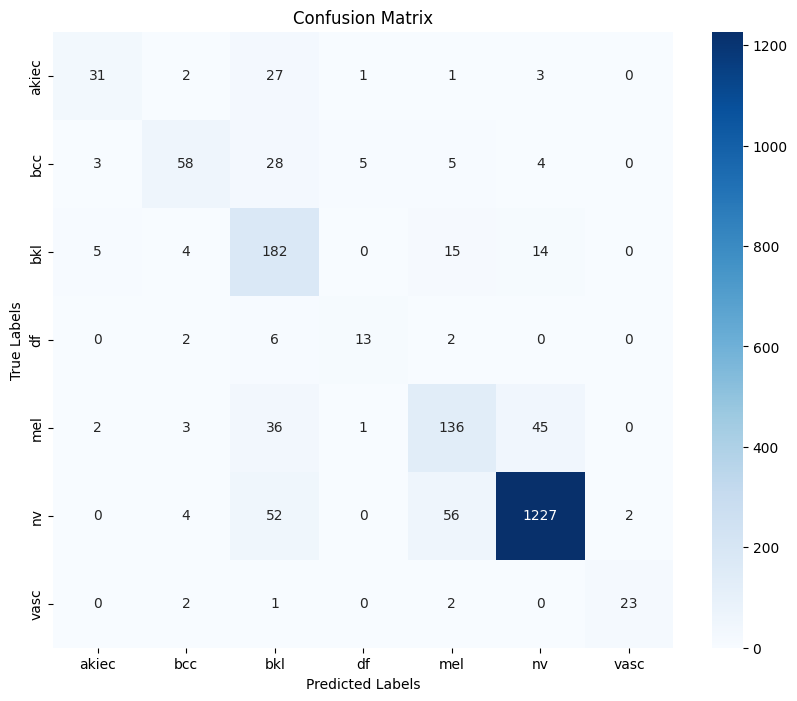

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


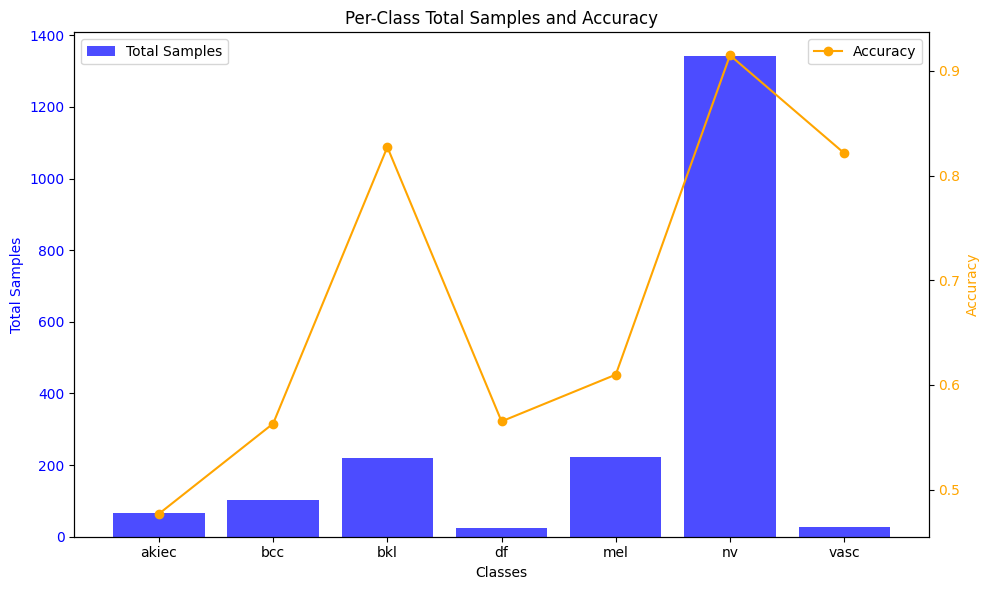

In [21]:
label_counts = np.bincount(y_true)
class_accuracies = np.diag(cm) / label_counts

classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
total_counts = label_counts
accuracies = class_accuracies

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(classes, total_counts, alpha=0.7, label='Total Samples', color='blue')
ax1.set_xlabel('Classes')
ax1.set_ylabel('Total Samples', color='blue')
ax1.set_title('Per-Class Total Samples and Accuracy')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(classes, accuracies, color='orange', marker='o', label='Accuracy')
ax2.set_ylabel('Accuracy', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

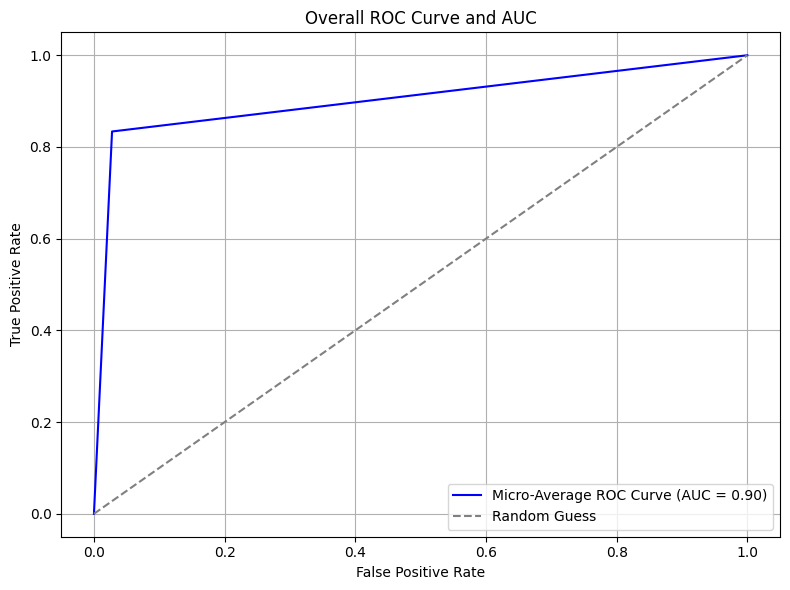

In [22]:
num_classes = len(classes)
y_true_one_hot = label_binarize(y_true, classes=np.arange(num_classes))

y_pred_prob = np.zeros_like(y_true_one_hot)
for i, label in enumerate(y_pred):
    y_pred_prob[i, label] = 1

fpr, tpr, _ = roc_curve(y_true_one_hot.ravel(), y_pred_prob.ravel())
roc_auc = roc_auc_score(y_true_one_hot, y_pred_prob, average="micro")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"Micro-Average ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Overall ROC Curve and AUC")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()


In [23]:
print("ROC AUC Score (Micro):", roc_auc_score(y_true, y_pred_prob, multi_class='ovr', average='micro'))
print("ROC AUC Score (Macro):", roc_auc_score(y_true, y_pred_prob, multi_class='ovr', average='macro'))
print("ROC AUC Score (Weighted):", roc_auc_score(y_true, y_pred_prob, multi_class='ovr', average='weighted'))

print("AUC Scores Per Class:")
for i, class_name in enumerate(class_names):
    class_roc_auc = roc_auc_score(y_true_one_hot[:, i], y_pred_prob[:, i])
    print(f"{class_name}: {class_roc_auc:.2f}")

ROC AUC Score (Micro): 0.9030204692960561
ROC AUC Score (Macro): 0.8236297236976708
ROC AUC Score (Weighted): 0.8760066417762359
AUC Scores Per Class:
akiec: 0.74
bcc: 0.78
bkl: 0.87
df: 0.78
mel: 0.78
nv: 0.91
vasc: 0.91
